# Functions

In [47]:
import numpy as np
from mpmath import mp
from tqdm import tqdm
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from utils import save_exponents_csv
# from renormalization_hp import *

mp.dps = 100  # Set desired precision

plus_configs = [
    ([1,1,1], lambda J1, J2: 2*J1 + J2, mp.mpf('3')),
    ([1,1,-1], lambda J1, J2: -J2, mp.mpf('1')),
    ([1,-1,1], lambda J1, J2: -2*J1 + J2, mp.mpf('1')),
    ([-1,1,1], lambda J1, J2: -J2, mp.mpf('1'))
]

minus_configs = [
    ([-1,-1,-1], lambda J1, J2: 2*J1 + J2, mp.mpf('-3')),
    ([-1,-1,1], lambda J1, J2: -J2, mp.mpf('-1')),
    ([-1,1,-1], lambda J1, J2: -2*J1 + J2, mp.mpf('-1')),
    ([1,-1,-1], lambda J1, J2: -J2, mp.mpf('-1'))
]

def get_J(d, J0, n):
    if d <= 0:
        return mp.mpf(0)
    return mp.mpf(J0) / mp.power(mp.mpf(d), mp.mpf(n))

def mp_logsumexp(lst):
    if not lst:
        return mp.ninf
    a_max = max(lst)
    if mp.isinf(a_max):
        return a_max
    tmp = sum(mp.exp(a - a_max) for a in lst)
    return a_max + mp.log(tmp)

def compute_R_logs(start, J_func, h):
    J1 = J_func(1)
    J2 = J_func(2)
    distances = [(iL, iR, (start + iR) - (1 + iL)) for iL in range(3) for iR in range(3)]

    def get_totals(left_confs, right_confs):
        totals = []
        for spinsL, El_func, sumL in left_confs:
            El = El_func(J1, J2)
            for spinsR, Er_func, sumR in right_confs:
                Er = Er_func(J1, J2)
                Eint = mp.mpf('0')
                for iL, iR, d in distances:
                    Eint += mp.mpf(spinsL[iL] * spinsR[iR]) * J_func(d)
                total = El + Er + Eint + h * (sumL + sumR)
                totals.append(total)
        return totals

    totals_pp = get_totals(plus_configs, plus_configs)
    totals_pm = get_totals(plus_configs, minus_configs)
    totals_mp = get_totals(minus_configs, plus_configs)
    totals_mm = get_totals(minus_configs, minus_configs)

    log_R_pp = mp_logsumexp(totals_pp)
    log_R_pm = mp_logsumexp(totals_pm)
    log_R_mp = mp_logsumexp(totals_mp)
    log_R_mm = mp_logsumexp(totals_mm)

    return log_R_pp, log_R_pm, log_R_mp, log_R_mm

def compute_J_prime_func(start, J_func, h):
    log_pp, log_pm, log_mp, log_mm = compute_R_logs(start, J_func, h)
    if mp.isinf(log_pm) or mp.isinf(log_mp):
        return mp.inf
    ln_arg = log_pp + log_mm - log_pm - log_mp
    return mp.mpf('0.25') * ln_arg

#def compute_H_prime_func(J_func, h):
#    start = 4  # For r'=1
#    log_pp, _, _, log_mm = compute_R_logs(start, J_func, h)
#    ln_arg = log_pp - log_mm
#    return mp.mpf('0.25') * ln_arg

def compute_H_prime_func(start, J_func, h):
    log_pp, _, _, log_mm = compute_R_logs(start, J_func, h)
    ln_arg = log_pp - log_mm
    return mp.mpf('0.25') * ln_arg

def generate_rg_flow_no_viz(J0, n, max_k, num_steps):
    J_func = lambda d: get_J(d, J0, n) if d > 0 else mp.mpf(0)
    rs = list(range(1, max_k + 1))
    initial_Js = [J_func(r) for r in rs]
    all_Js = [initial_Js]
    h = mp.mpf(0)  # Fixed to 0 for the flow
    for step in range(1, num_steps + 1):
        Jps = []
        for r in rs:
            start = 3 * r + 1
            Jp = compute_J_prime_func(start, J_func, h)
            Jps.append(Jp)
        all_Js.append(Jps)
        J_dict = {r: Jps[r-1] for r in rs}
        J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
    return all_Js

def construct_recursion_matrix(J0, n, max_k, num_steps, matrix_size=5, epsilon=1e-6):
    all_Js = generate_rg_flow_no_viz(J0, n, max_k, num_steps)
    if len(all_Js) < 2:
        raise ValueError("Need at least 2 steps for derivatives")

    # Extract first matrix_size from last two steps
    J_k_minus_1 = all_Js[-2][:matrix_size]  # list of mp.mpf, truncated
    J_k = all_Js[-1][:matrix_size]  # list of mp.mpf, truncated

    M = matrix_size  # Size of matrix
    jac = np.zeros((M, M))

    # Define compute_T truncated to M
    def compute_T(J_vec_mp):
        J_dict = {r+1: J_vec_mp[r] for r in range(M)}
        J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
        J_prime = []
        h = mp.mpf(0)  # h=0
        for r in range(1, M+1):
            start = 3 * r + 1
            Jp = compute_J_prime_func(start, J_func, h)
            J_prime.append(Jp)
        return J_prime

    epsilon_mp = mp.mpf(epsilon)

    J_k_minus_1_float = np.array([float(j) for j in J_k_minus_1])
    J_k_float = np.array([float(j) for j in J_k])

    for s in range(M):
        J_pert_mp = [j for j in J_k_minus_1]  # copy list of mp
        J_pert_mp[s] += epsilon_mp
        T_pert_mp = compute_T(J_pert_mp)
        T_pert_float = np.array([float(j) for j in T_pert_mp])
        jac[:, s] = (T_pert_float - J_k_float) / float(epsilon)

    return jac

def find_J_c(n, max_k=1000, tol=1e-6, J_low=1e-10, J_high=3.0):
    if n <= 0 or n >= 2:
        raise ValueError("n must be between 0 and 2, excluding the edges.")

    start_track = 3
    max_steps = 5
    tol = mp.mpf(tol)
    J_low = mp.mpf(J_low)
    J_high = mp.mpf(J_high)
    rs = list(range(1, max_k + 1))

    def compute_flow(J0):
        J_func = lambda d: get_J(d, J0, n) if d > 0 else mp.mpf(0)
        all_Js = [[J_func(r) for r in rs]]
        h = mp.mpf(0)
        for step in range(1, max_steps + 1):
            Jps = [compute_J_prime_func(3 * r + 1, J_func, h) for r in rs]
            all_Js.append(Jps)
            if step >= start_track:
                J_r2_current = Jps[1]
                J_r2_previous = all_Js[-2][1]
                if J_r2_current > J_r2_previous:
                    return all_Js, True  # Growing (ferromagnetic)
                if J_r2_current < J_r2_previous:
                    return all_Js, False  # Decaying (paramagnetic)
            J_dict = {r: Jps[r-1] for r in rs}
            J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
        # Fallback
        J_r2_initial = all_Js[0][1]
        J_r2_final = all_Js[-1][1]
        return all_Js, J_r2_final > J_r2_initial

    iter_count = 0
    while J_high - J_low > tol and iter_count < 100:
        iter_count += 1
        J_mid = (J_low + J_high) / 2
        _, is_growing = compute_flow(J_mid)
        if is_growing:
            J_high = J_mid  # Growing: search lower half
        else:
            J_low = J_mid  # Decaying: search upper half
    return (J_low + J_high) / 2

def compute_dH_prime_dH(J0, n, max_k, num_steps, h_small='1e-30'):
    """
    Compute the derivative ∂H'/∂H at low temperature using finite differences.
    
    Parameters:
    J0 (float): Initial coupling strength (high for low temperature)
    n (float): Power-law exponent
    max_k (int): Maximum distance for couplings
    num_steps (int): Number of RG steps to reach fixed point
    h_small (str or float): Small magnetic field perturbation
    
    Returns:
    float: Approximate ∂H'/∂H
    """
    # Generate RG flow to get fixed-point couplings
    all_Js = generate_rg_flow_no_viz(J0, n, max_k, num_steps)
    J_fixed = all_Js[-1]  # Take the last step as fixed point
    J_func_fixed = lambda d: J_fixed[d-1] if 1 <= d <= max_k else mp.mpf(0)
    
    # Compute H' with small perturbation h_small
    h_small = mp.mpf(h_small)
    H_prime = compute_H_prime_func(4, J_func_fixed, h_small)  # r'=1, start=4
    dH_prime_dH = H_prime / h_small
    
    return float(dH_prime_dH)

# Single calculation

In [2]:
n = 1  # Exponent n
max_k = 1000  # Max distance for flow
num_steps = 5  # Number of RG steps
matrix_size = 5  # Number of first J values for matrix
b = 3.0  # Scale factor

# Find critical Jc
Jc = find_J_c(n, max_k=max_k, tol=1e-6, J_low=1e-10, J_high=3.0)
print(f"Critical Jc for n={n}: {float(Jc)}")

# Compute recursion matrix at Jc
M_matrix = construct_recursion_matrix(Jc, n, max_k, num_steps, matrix_size=matrix_size)
print("Recursion Matrix M:")
print(M_matrix)

# Compute eigenvalues
eigenvalues = np.linalg.eigvals(M_matrix)
eigenvalues = sorted(eigenvalues, key=abs, reverse=True)
lambda_t = eigenvalues[0]
yT = np.log(abs(lambda_t)) / np.log(b) if abs(lambda_t) > 0 else 0
nu = 1 / yT if yT != 0 else np.inf
alpha = 2 - 1 / yT if yT != 0 else -np.inf
print(f"Largest eigenvalue λ_t = {lambda_t:.6f}")
print(f"ν = {nu:.6f}, α = {alpha:.6f}")

# Compute yH, eta, delta
all_Js = generate_rg_flow_no_viz(Jc, n, max_k, num_steps)
J_fixed = all_Js[-1]
J_func_fixed = lambda d: J_fixed[d-1] if 1 <= d <= max_k else mp.mpf(0)

h_small = mp.mpf('1e-30')
H_prime = compute_H_prime_func(J_func_fixed, h_small)
dyh = H_prime / h_small
yH = float(mp.log(dyh) / mp.log(mp.mpf('3')))

eta = 1.0 - yH
delta = yT / (1.0 - yH)

print(f"yH = {yH:.6f}")
print(f"η = {eta:.6f}")
print(f"δ = {delta:.6f}")

Critical Jc for n=1: 0.13968837270734324
Recursion Matrix M:
[[ 5.20986952e-01  8.82475463e-01  1.03124960e+00  7.13482425e-01
   3.06883209e-01]
 [-4.07903685e+04 -4.07903802e+04 -4.07904056e+04 -4.07901034e+04
  -4.07897034e+04]
 [-4.52321945e+04 -4.52321945e+04 -4.52321945e+04 -4.52321945e+04
  -4.52321945e+04]
 [-3.36441486e+04 -3.36441486e+04 -3.36441486e+04 -3.36441486e+04
  -3.36441486e+04]
 [-2.68146264e+04 -2.68146264e+04 -2.68146264e+04 -2.68146264e+04
  -2.68146264e+04]]
Largest eigenvalue λ_t = -146480.385853+0.000000j
ν = 0.092362, α = 1.907638
yH = 0.559059
η = 0.440941
δ = 24.554220


# Multiple calculations

In [32]:
# Calculate and plot exponents for multiple n values with precalculated Jc values
# Load the saved data
critical_temp_array = np.load('../data/critical_interaction_data.npy')
n_values = critical_temp_array[:,0]
Jcs = critical_temp_array[:,1]

max_k = 2000
num_steps = 2
matrix_size = 5
b = 3.0
h_small = mp.mpf('1e-30')

# Lists to store exponents
nus = []
alphas = []
etas = []
deltas = []

for n, Jc in critical_temp_array:
    print(f"Processing n = {n:.2f}")
    
    # Compute recursion matrix at Jc
    M_matrix = construct_recursion_matrix(Jc, n, max_k, num_steps, matrix_size=matrix_size)
    
    # Compute eigenvalues for thermal exponents
    eigenvalues = np.linalg.eigvals(M_matrix)
    eigenvalues = sorted(eigenvalues, key=abs, reverse=True)
    lambda_t = eigenvalues[0]
    yT = np.log(abs(lambda_t)) / np.log(b) if abs(lambda_t) > 0 else 0
    nu = 1 / yT if yT != 0 else np.inf
    alpha = 2 - 1 / yT if yT != 0 else -np.inf
    nus.append(nu)
    alphas.append(alpha)
    print(f"  ν = {nu:.6f}, α = {alpha:.6f}")
    
    # Compute magnetic exponents
    all_Js = generate_rg_flow_no_viz(Jc, n, max_k, num_steps)
    J_fixed = all_Js[-1]
    J_func_fixed = lambda d: J_fixed[d-1] if 1 <= d <= max_k else mp.mpf(0)
    
    H_prime = compute_H_prime_func(J_func_fixed, h_small)
    dyh = H_prime / h_small
    yH = float(mp.log(dyh) / mp.log(mp.mpf('3')))
    
    eta = 1.0 - yH
    delta = yT / (1.0 - yH)
    etas.append(eta)
    deltas.append(delta)
    print(f"  η = {eta:.6f}, δ = {delta:.6f}")

Processing n = 0.74
  ν = 0.128107, α = 1.871893
  η = 0.626358, δ = 12.462478
Processing n = 0.75
  ν = 0.120106, α = 1.879894
  η = 0.622768, δ = 13.369278
Processing n = 0.76
  ν = 0.111065, α = 1.888935
  η = 0.613355, δ = 14.679515
Processing n = 0.78
  ν = 0.106746, α = 1.893254
  η = 0.604125, δ = 15.506789
Processing n = 0.79
  ν = 0.103890, α = 1.896110
  η = 0.594570, δ = 16.189129
Processing n = 0.80
  ν = 0.101893, α = 1.898107
  η = 0.585222, δ = 16.770098
Processing n = 0.82
  ν = 0.100351, α = 1.899649
  η = 0.575824, δ = 17.305582
Processing n = 0.83
  ν = 0.099111, α = 1.900889
  η = 0.566382, δ = 17.814259
Processing n = 0.84
  ν = 0.098084, α = 1.901916
  η = 0.556899, δ = 18.307377
Processing n = 0.86
  ν = 0.097214, α = 1.902786
  η = 0.547381, δ = 18.792322
Processing n = 0.87
  ν = 0.096466, α = 1.903534
  η = 0.537834, δ = 19.274275
Processing n = 0.88
  ν = 0.096039, α = 1.903961
  η = 0.531707, δ = 19.583085
Processing n = 0.88
  ν = 0.095839, α = 1.904161
  η

# Plot and save data

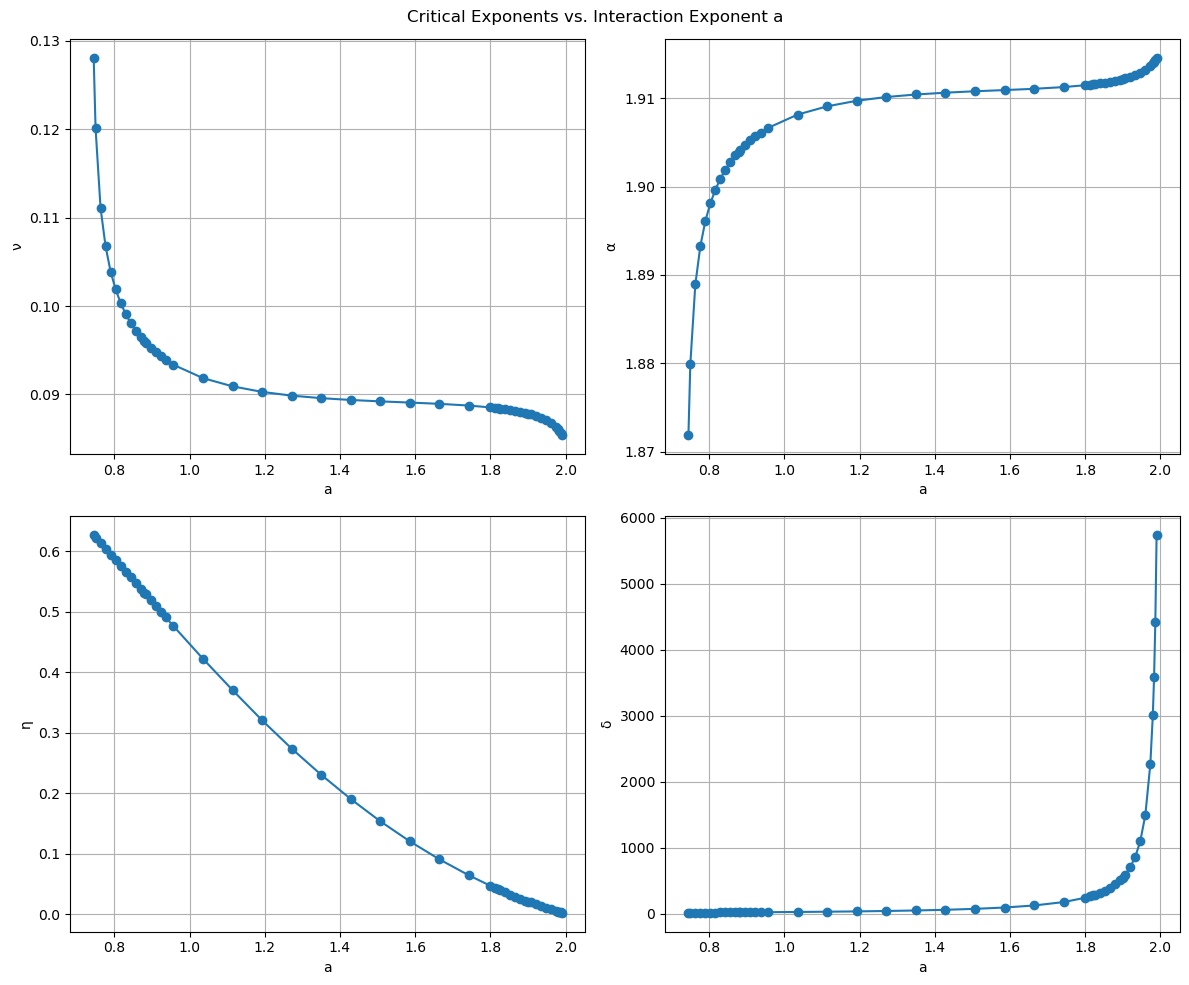

In [37]:
import matplotlib.pyplot as plt
# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].plot(n_values, nus, marker='o', label='ν')
axs[0, 0].set_xlabel('a')
axs[0, 0].set_ylabel('ν')
axs[0, 0].grid(True)

axs[0, 1].plot(n_values, alphas, marker='o', label='α')
axs[0, 1].set_xlabel('a')
axs[0, 1].set_ylabel('α')
axs[0, 1].grid(True)

axs[1, 0].plot(n_values, etas, marker='o', label='η')
axs[1, 0].set_xlabel('a')
axs[1, 0].set_ylabel('η')
axs[1, 0].grid(True)

axs[1, 1].plot(n_values, deltas, marker='o', label='δ')
axs[1, 1].set_xlabel('a')
axs[1, 1].set_ylabel('δ')
#axs[1, 1].set_ylim(0, 1000)
axs[1, 1].grid(True)

plt.suptitle('Critical Exponents vs. Interaction Exponent a')
plt.tight_layout()
#plt.savefig("../results/all_exponents.png")
plt.show()

In [46]:
# Save the results after calculation
save_exponents_csv(n_values, Jcs, nus, alphas, etas, deltas, filename="../data/exponents.csv")

Results saved to ../data/exponents.csv


# Derivative of H

In [50]:
n = 1  # Power-law exponent
max_k = 1000  # Max distance for flow
num_steps = 5  # Number of RG steps
h_small = '1e-30'  # Small perturbation for numerical derivative

# Find critical Jc
#Jc = find_J_c(n, max_k=max_k, tol=1e-6, J_low=1e-10, J_high=3.0)
#print(f"Critical Jc for n={n}: {float(Jc)}")

# Choose a low temperature (J0 > Jc)
#J0_low_T = float(Jc) * 1.5  # 50% above critical J for low temperature
J0_low_T = 0.4
dH_prime_dH = compute_dH_prime_dH(J0_low_T, n, max_k, num_steps, h_small)
print(f"∂H'/∂H at J0={J0_low_T} (low temperature) for n={n}: {dH_prime_dH:.6f}")

∂H'/∂H at J0=0.4 (low temperature) for n=1: 3.000000
